#### This is a python / R implementation for spatial analysis of radar rainfall fields.  All courtesy for the R code implementation goes to Marc Schleiss

# Notes before running:

o) make sure to have installed R properly

o) install the python library rpy2

- linux/mac users should be fine by just pip install rpy2 
- for windows, consider using anaconda and install rpy2

o) install the R libraries sp, gstat and intamap inside the R environment (best as sudo/adminstrator):

```
install.packages("sp")
install.packages("gstat")
install.packages("intamap")
```

## Import python / R interface packages

In [1]:
from rpy2.robjects.packages import importr
from rpy2.robjects import r
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

## Inside the R environment import these geospatial packages

In [2]:
sp = importr('sp')
gstat = importr('gstat')
intamap = importr('intamap')

#### Set colors within the R environment

In [3]:
r('jet.colors  <- c("#00007F","blue","#007FFF","cyan","#7FFF7F","yellow","#FF7F00","red","#7F0000")')
r('col.palette <- colorRampPalette(jet.colors)')

R object with classes: ('function',) mapped to:
<SignatureTranslatedFunction - Python:0x7f845909bf48 / R:0x555578ec0730>

## Read pandas coordinates of the radar grid

In [4]:
coords = pd.read_csv('./radar_xy.csv', header=None)
coords.columns = ['x', 'y']
coords.head()

,x,y
0,3649.014148,1745.990418
1,3650.003652,1745.945446
2,3651.030377,1746.036880
3,3652.020031,1745.992300
4,3653.009769,1745.947910


### Read the 24h dataset and (re)arange the pandas DataFrame

In [5]:
rainfall = pd.read_csv('./radar_sent/radar_snap_24h_2011_08_05-00_00.csv', header=None)
rainfall = pd.DataFrame(rainfall.iloc[0,5::])
rainfall.index = np.arange(0,len(rainfall),1)
rainfall.columns = ['R']
rainfall['x'] = coords['x']
rainfall['y'] = coords['y']
rainfall.head()

,R,x,y
0,3.35,3649.014148,1745.990418
1,5.65,3650.003652,1745.945446
2,5.51,3651.030377,1746.036880
3,6.24,3652.020031,1745.992300
4,7.64,3653.009769,1745.947910


### Activate the pandas to R conversion interface

In [6]:
from rpy2.robjects import pandas2ri
pandas2ri.activate()

### Select only gridpoints > 0mm rain (wet mask) and assign it in the R environment

In [7]:
mask = rainfall.R>0
rainfall = rainfall[mask]

r_df = pandas2ri.py2ri(rainfall)
r.assign('mydata', r_df)

R,x,y
3.350000,3649.014148,1745.990418
5.650000,3650.003652,1745.945446
5.510000,3651.030377,1746.036880


### Transform dataset in R to geospatial dataset

In [8]:
r('''
mydata <- data.frame(mydata)
coordinates(mydata) <- ~x+y
''')

R object with classes: ('formula',) mapped to:
<RObject - Python:0x7f8459b79148 / R:0x555578cdced0>

### Bypass plot R map

In [10]:
r('''
RAD24 <- read.table("./radar_sent/radar_snap_24h_2011_08_05-00_00.csv",sep=",",colClasses="numeric")
RAD24 <- as.numeric(as.vector(RAD24))
RAD24 <- RAD24[6:length(RAD24)]
png("map_24h.png",height=900,width=900)
ncuts <- 20
cuts <- seq(min(RAD24,na.rm=TRUE),max(RAD24,na.rm=TRUE),length=ncuts)
print(spplot(mydata["R"],xlab="East [m]",ylab="North [m]",key.space="right",cuts=cuts,region=TRUE,col.regions=col.palette(ncuts),main="Rainfall [mm]",scales=list(draw=TRUE)))
dev.off()
''')

array([1], dtype=int32)

### Generate a isotropic variogram (2km separated lags, max 100km)

In [11]:
p_myiso = r('myiso <- variogram(R~1,mydata,width=2,cutoff=100)')

In [12]:
p_myiso.head()

,np,dist,gamma,dir.hor,dir.ver,id
1,97340.0,1.361011,21.909125,0.0,0.0,var1
2,342089.0,2.980286,59.871361,0.0,0.0,var1
3,599568.0,4.979613,105.459092,0.0,0.0,var1
4,781415.0,6.968800,147.173973,0.0,0.0,var1
5,1041462.0,8.972910,183.165594,0.0,0.0,var1


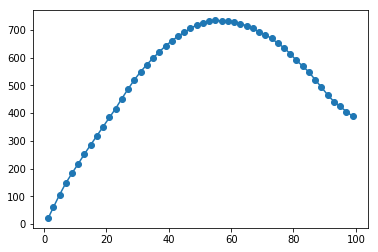

In [13]:
plt.plot(p_myiso['dist'], p_myiso['gamma'], '-o')

### Generate and save the 2D variogram map

In [14]:
p_myiso_map = r('myisomap <- variogram(R~1,mydata,width=2,cutoff=50,map=TRUE)')

r('''
png("myvariogram_map_24h.png",height=600,width=600)
print(plot(myisomap))
dev.off()
''')

array([1], dtype=int32)

### Investigate the (an)isotropy of the dataset

#### Only possible with up to 1499 values. Therefore we sort the rainfall values descendingly and assign the sorted dataset to the R environment.

In [15]:
rain_sorted = rainfall.sort_values('R', ascending=False)
rain_sorted = rain_sorted.iloc[0:1499]
rs_df = pandas2ri.py2ri(rain_sorted)
r.assign('data_sorted', rs_df)
r('''
data_sorted <- data.frame(data_sorted)
coordinates(data_sorted) <- ~x+y
''')

R object with classes: ('formula',) mapped to:
<RObject - Python:0x7f84456f00c8 / R:0x5555844db630>

#### Returns the direction of the minumum variablity clockwise from North and the anisotropy ratio

In [16]:
r('''
hat.anis <- estimateAnisotropy(data_sorted,"R")
anis <- c(90-hat.anis$direction,1/hat.anis$ratio)
''')

array([ 99.95886126,   0.78840942])

### Compute directional variograms with anisotropy direction

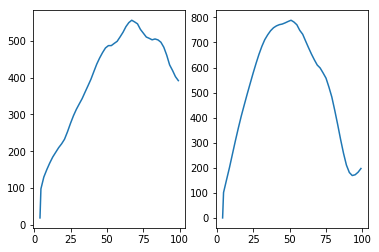

In [17]:
dir_var = r('directional_variograms <- variogram(R~1,mydata,width=2,cutoff=100,alpha=c(99.9,189.9),tol.hor=5)')

dir_1 = dir_var['dir.hor']==99.9
plt.figure()
plt.subplot(121)
plt.plot(dir_var.dist[dir_1], dir_var.gamma[dir_1])
plt.subplot(122)
plt.plot(dir_var.dist[~dir_1], dir_var.gamma[~dir_1])

### Fit initial spherical variogram to isotropic variogram

In [18]:
r('initial_vario_sph <- vgm(psill=500,model="Sph",range=40,nugget=0)')
sph_fitted = r('fitted_vario_sph <- fit.variogram(myiso,initial_vario_sph)')
print(sph_fitted)

  model       psill      range  kappa  ang1  ang2  ang3  anis1  anis2
1   Nug    0.000000   0.000000    0.0   0.0   0.0   0.0    1.0    1.0
2   Sph  669.925474  49.911368    0.5   0.0   0.0   0.0    1.0    1.0


#### Save image of fitted variogram

In [19]:
r('''
png("fitted_isotropic_variogram_sph_24h.png",height=600,width=900)
print(plot(myiso,fitted_vario_sph))
dev.off()
''')

array([1], dtype=int32)

##### fitted range

In [20]:
r('range  <- fitted_vario_sph$range[2]')

array([ 49.91136764])

##### fitted nugget

In [21]:
r('nugget <- fitted_vario_sph$psill[1]')

array([ 0.])

##### fitted sill

In [22]:
r('sill   <- sum(fitted_vario_sph$psill)')

array([ 669.9254743])

##### sum of squared errors

In [23]:
r('SSErr_sph <- attributes(fitted_vario_sph)$SSErr')

array([  2.04400622e+08])

### Fit exponential model

In [24]:
r('initial_vario_exp <- vgm(psill=500,model="Exp",range=40/3,nugget=0)')
exp_fitted = r('fitted_vario_exp <- fit.variogram(myiso,initial_vario_exp)')

##### sum of squared errors

In [25]:
r('SSErr_exp  <- attributes(fitted_vario_exp)$SSErr')

array([  4.90458050e+08])

#### Save image

In [26]:
r('''
png("fitted_isotropic_variogram_exp_24h.png",height=600,width=900)
print(plot(myiso,fitted_vario_exp))
dev.off()
''')

array([1], dtype=int32)

# Repeat everything with 15 minute and 3h field(s)

In [27]:
rain_15_min_1 = pd.read_csv('./radar_sent/radar_snap_2011_08_01-00_00.csv', header=None)
rain_15_min_1 = pd.DataFrame(rain_15_min_1.iloc[0,5::])
rain_15_min_1.index = np.arange(0,len(rain_15_min_1),1)
rain_15_min_1.columns = ['R']
rain_15_min_1['x'] = coords['x']
rain_15_min_1['y'] = coords['y']

rain_15_min_2 = pd.read_csv('./radar_sent/radar_snap_2011_08_05-16_00.csv', header=None)
rain_15_min_2 = pd.DataFrame(rain_15_min_2.iloc[0,5::])
rain_15_min_2.index = np.arange(0,len(rain_15_min_2),1)
rain_15_min_2.columns = ['R']
rain_15_min_2['x'] = coords['x']
rain_15_min_2['y'] = coords['y']

rain_3h = pd.read_csv('./radar_sent/radar_snap_3h_2011_08_05-15_00.csv', header=None)
rain_3h = pd.DataFrame(rain_3h.iloc[0,5::])
rain_3h.index = np.arange(0,len(rain_3h),1)
rain_3h.columns = ['R']
rain_3h['x'] = coords['x']
rain_3h['y'] = coords['y']

In [28]:
mask = rain_15_min_1.R>0
rain_15_min_1 = rain_15_min_1[mask]
r_df_15_1 = pandas2ri.py2ri(rain_15_min_1)
r.assign('mydata_15_1', r_df_15_1)

mask = rain_15_min_2.R>0
rain_15_min_2 = rain_15_min_2[mask]
r_df_15_2 = pandas2ri.py2ri(rain_15_min_2)
r.assign('mydata_15_2', r_df_15_2)

mask = rain_3h.R>0
rain_3h = rain_3h[mask]
r_df_3h = pandas2ri.py2ri(rain_3h)
r.assign('mydata_3h', r_df_3h)

R,x,y
3.120000,3649.014148,1745.990418
4.220000,3650.003652,1745.945446
5.050000,3651.030377,1746.036880


In [29]:
r('''
mydata_15_1 <- data.frame(mydata_15_1)
coordinates(mydata_15_1) <- ~x+y
''')
p_myiso_1 = r('myiso_15_1 <- variogram(R~1,mydata_15_1,width=2,cutoff=100)')

r('''
mydata_15_2 <- data.frame(mydata_15_2)
coordinates(mydata_15_2) <- ~x+y
''')
p_myiso_2 = r('myiso_15_2 <- variogram(R~1,mydata_15_2,width=2,cutoff=100)')

r('''
mydata_3h <- data.frame(mydata_3h)
coordinates(mydata_3h) <- ~x+y
''')
p_myiso_3 = r('myiso_3h <- variogram(R~1,mydata_3h,width=2,cutoff=100)')

In [30]:
print(p_myiso_1.head())
print(p_myiso_2.head())
print(p_myiso_3.head())

         np      dist      gamma  dir.hor  dir.ver    id
1   33608.0  1.355468   2.536012      0.0      0.0  var1
2  113786.0  2.970968   6.378655      0.0      0.0  var1
3  190011.0  4.974815  11.195021      0.0      0.0  var1
4  234194.0  6.960236  14.600749      0.0      0.0  var1
5  303104.0  8.968250  17.308080      0.0      0.0  var1
         np      dist      gamma  dir.hor  dir.ver    id
1   24348.0  1.347210   2.311395      0.0      0.0  var1
2   85229.0  2.979932   5.878041      0.0      0.0  var1
3  139734.0  4.976117   9.704100      0.0      0.0  var1
4  177768.0  6.963034  11.939585      0.0      0.0  var1
5  228038.0  8.974290  12.970817      0.0      0.0  var1
         np      dist       gamma  dir.hor  dir.ver    id
1   65588.0  1.355036   14.184884      0.0      0.0  var1
2  228370.0  2.979035   40.795332      0.0      0.0  var1
3  388611.0  4.978376   75.172640      0.0      0.0  var1
4  500936.0  6.967707  111.636063      0.0      0.0  var1
5  659905.0  8.974731  145

##### Bypass plot R map

In [31]:
r('''
RAD24 <- read.table("./radar_sent/radar_snap_2011_08_01-00_00.csv",sep=",",colClasses="numeric")
RAD24 <- as.numeric(as.vector(RAD24))
RAD24 <- RAD24[6:length(RAD24)]
png("map_15_1.png",height=900,width=900)
ncuts <- 20
cuts <- seq(min(RAD24,na.rm=TRUE),max(RAD24,na.rm=TRUE),length=ncuts)
print(spplot(mydata_15_1["R"],xlab="East [m]",ylab="North [m]",key.space="right",cuts=cuts,region=TRUE,col.regions=col.palette(ncuts),main="Rainfall [mm]",scales=list(draw=TRUE)))
dev.off()

RAD24 <- read.table("./radar_sent/radar_snap_2011_08_05-16_00.csv",sep=",",colClasses="numeric")
RAD24 <- as.numeric(as.vector(RAD24))
RAD24 <- RAD24[6:length(RAD24)]
png("map_15_2.png",height=900,width=900)
ncuts <- 20
cuts <- seq(min(RAD24,na.rm=TRUE),max(RAD24,na.rm=TRUE),length=ncuts)
print(spplot(mydata_15_2["R"],xlab="East [m]",ylab="North [m]",key.space="right",cuts=cuts,region=TRUE,col.regions=col.palette(ncuts),main="Rainfall [mm]",scales=list(draw=TRUE)))
dev.off()

RAD24 <- read.table("./radar_sent/radar_snap_3h_2011_08_05-15_00.csv",sep=",",colClasses="numeric")
RAD24 <- as.numeric(as.vector(RAD24))
RAD24 <- RAD24[6:length(RAD24)]
png("map_3h.png",height=900,width=900)
ncuts <- 20
cuts <- seq(min(RAD24,na.rm=TRUE),max(RAD24,na.rm=TRUE),length=ncuts)
print(spplot(mydata_3h["R"],xlab="East [m]",ylab="North [m]",key.space="right",cuts=cuts,region=TRUE,col.regions=col.palette(ncuts),main="Rainfall [mm]",scales=list(draw=TRUE)))
dev.off()
''')

array([1], dtype=int32)

##### Isotropic variograms

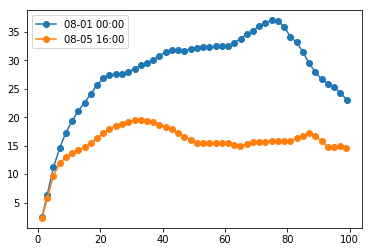

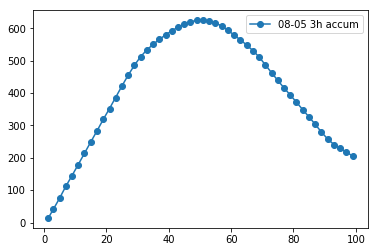

In [32]:
plt.plot(p_myiso_1['dist'], p_myiso_1['gamma'], '-o')
plt.plot(p_myiso_2['dist'], p_myiso_2['gamma'], '-o')
plt.legend(['08-01 00:00', '08-05 16:00'])
plt.figure()
plt.plot(p_myiso_3['dist'], p_myiso_3['gamma'], '-o')
plt.legend(['08-05 3h accum'])

##### Plot R variogram map

In [33]:
r('''
myiso_15_1_map <- variogram(R~1,mydata_15_1,width=2,cutoff=50,map=TRUE)
png("myvariogram_map_15_1.png",height=600,width=600)
print(plot(myiso_15_1_map))
dev.off()

myiso_15_2_map <- variogram(R~1,mydata_15_2,width=2,cutoff=50,map=TRUE)
png("myvariogram_map_15_2.png",height=600,width=600)
print(plot(myiso_15_2_map))
dev.off()

myiso_3h_map <- variogram(R~1,mydata_3h,width=2,cutoff=50,map=TRUE)
png("myvariogram_map_3h.png",height=600,width=600)
print(plot(myiso_3h_map))
dev.off()
''')

array([1], dtype=int32)

### (An)isotropy and directional variogram

###### Sort and convert to R spatial dataframe

In [34]:
rain_sorted_15_1 = rain_15_min_1.sort_values('R', ascending=False)
rain_sorted_15_1 = rain_sorted_15_1.iloc[0:1499]
rs_df_15_1 = pandas2ri.py2ri(rain_sorted_15_1)
r.assign('data_sorted_15_1', rs_df_15_1)

rain_sorted_15_2 = rain_15_min_2.sort_values('R', ascending=False)
rain_sorted_15_2 = rain_sorted_15_2.iloc[0:1499]
rs_df_15_2 = pandas2ri.py2ri(rain_sorted_15_2)
r.assign('data_sorted_15_2', rs_df_15_2)

rain_sorted_3h = rain_3h.sort_values('R', ascending=False)
rain_sorted_3h = rain_sorted_3h.iloc[0:1499]
rs_df_3h = pandas2ri.py2ri(rain_sorted_3h)
r.assign('data_sorted_3h', rs_df_3h)

r('''
data_sorted_15_1 <- data.frame(data_sorted_15_1)
coordinates(data_sorted_15_1) <- ~x+y

data_sorted_15_2 <- data.frame(data_sorted_15_2)
coordinates(data_sorted_15_2) <- ~x+y

data_sorted_3h <- data.frame(data_sorted_3h)
coordinates(data_sorted_3h) <- ~x+y
''')

R object with classes: ('formula',) mapped to:
<RObject - Python:0x7f844538db88 / R:0x555583fa92f0>

In [35]:
r('hat.anis <- estimateAnisotropy(data_sorted_15_1,"R")')
anis_15_1 = r('anis <- c(90-hat.anis$direction,1/hat.anis$ratio)')
print(anis_15_1)

r('hat.anis <- estimateAnisotropy(data_sorted_15_2,"R")')
anis_15_2 = r('anis <- c(90-hat.anis$direction,1/hat.anis$ratio)')
print(anis_15_2)

r('hat.anis <- estimateAnisotropy(data_sorted_3h,"R")')
anis_3h = r('anis <- c(90-hat.anis$direction,1/hat.anis$ratio)')
print(anis_3h)

[ 83.66255086   0.62384561]
[ 119.45351537    0.8361199 ]
[ 130.27650209    0.7719027 ]


In [36]:
dir_var_15_1 = r('directional_variograms_15_1 <- variogram(R~1,mydata_15_1,width=2,cutoff=100,alpha=c(83.6,173.6),tol.hor=5)')

dir_var_15_2 = r('directional_variograms_15_2 <- variogram(R~1,mydata_15_2,width=2,cutoff=100,alpha=c(119.45,209.45),tol.hor=5)')

dir_var_3h = r('directional_variograms_3h <- variogram(R~1,mydata_3h,width=2,cutoff=100,alpha=c(130.27,220.27),tol.hor=5)')

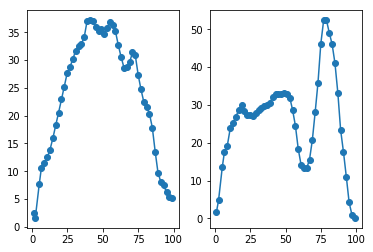

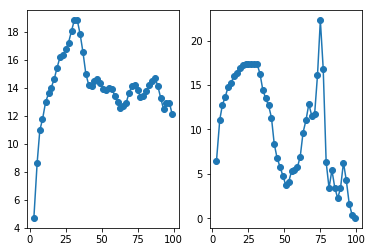

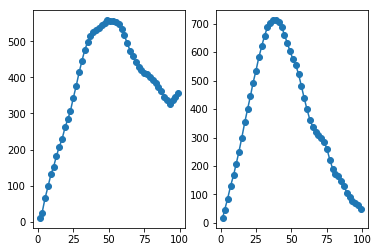

In [37]:
dir_var_15_1['dir.hor'] = np.around(dir_var_15_1['dir.hor'], decimals=2)
dir_15_1 = dir_var_15_1['dir.hor']==83.6
plt.figure()
plt.subplot(121)
plt.plot(dir_var_15_1.dist[dir_15_1], dir_var_15_1.gamma[dir_15_1], '-o')
plt.subplot(122)
plt.plot(dir_var_15_1.dist[~dir_15_1], dir_var_15_1.gamma[~dir_15_1], '-o')

dir_var_15_2['dir.hor'] = np.around(dir_var_15_2['dir.hor'], decimals=2)
dir_15_2 = dir_var_15_2['dir.hor']==119.45
plt.figure()
plt.subplot(121)
plt.plot(dir_var_15_2.dist[dir_15_2], dir_var_15_2.gamma[dir_15_2], '-o')
plt.subplot(122)
plt.plot(dir_var_15_2.dist[~dir_15_2], dir_var_15_2.gamma[~dir_15_2], '-o')

dir_var_3h['dir.hor'] = np.around(dir_var_3h['dir.hor'], decimals=2)
dir_3h = dir_var_3h['dir.hor']==130.27
plt.figure()
plt.subplot(121)
plt.plot(dir_var_3h.dist[dir_3h], dir_var_3h.gamma[dir_3h], '-o')
plt.subplot(122)
plt.plot(dir_var_3h.dist[~dir_3h], dir_var_3h.gamma[~dir_3h], '-o')

###### Spherical

In [38]:
r('''
initial_vario_sph_15_1 <- vgm(psill=30,model="Sph",range=60,nugget=0)
initial_vario_sph_15_2 <- vgm(psill=17,model="Sph",range=30,nugget=0)
initial_vario_sph_3h <- vgm(psill=500,model="Sph",range=40,nugget=0)
''')

fitted_vario_sph_15_1 = r('fitted_vario_sph_15_1 <- fit.variogram(myiso_15_1,initial_vario_sph_15_1)')
sph_15_1_sserr = r('SSErr_sph <- attributes(fitted_vario_sph_15_1)$SSErr')
fitted_vario_sph_15_2 = r('fitted_vario_sph_15_2 <- fit.variogram(myiso_15_2,initial_vario_sph_15_2)')
sph_15_2_sserr = r('SSErr_sph <- attributes(fitted_vario_sph_15_2)$SSErr')
fitted_vario_sph_3h = r('fitted_vario_sph_3h <- fit.variogram(myiso_3h,initial_vario_sph_3h)')
sph_3h_sserr = r('SSErr_sph <- attributes(fitted_vario_sph_3h)$SSErr')

r('''
png("fitted_isotropic_variogram_sph_15_1.png",height=600,width=900)
print(plot(myiso_15_1,fitted_vario_sph_15_1))
dev.off()

png("fitted_isotropic_variogram_sph_15_2.png",height=600,width=900)
print(plot(myiso_15_2,fitted_vario_sph_15_2))
dev.off()

png("fitted_isotropic_variogram_sph_3h.png",height=600,width=900)
print(plot(myiso_3h,fitted_vario_sph_3h))
dev.off()
''')

array([1], dtype=int32)

In [39]:
print('15_1:')
print(fitted_vario_sph_15_1.range[2])
print(fitted_vario_sph_15_1.psill[1])
print(sum(fitted_vario_sph_15_1.psill))
print(sph_15_1_sserr)
print('----------')
print('15_2:')
print(fitted_vario_sph_15_2.range[2])
print(fitted_vario_sph_15_2.psill[1])
print(sum(fitted_vario_sph_15_2.psill))
print(sph_15_2_sserr)
print('----------')
print('3h:')
print(fitted_vario_sph_3h.range[2])
print(fitted_vario_sph_3h.psill[1])
print(sum(fitted_vario_sph_3h.psill))
print(sph_3h_sserr)

15_1:
23.1581237031
0.78541751434
29.2084341386
[ 123120.99092959]
----------
15_2:
13.8724209244
0.401086236999
16.5198303643
[ 57848.87675276]
----------
3h:
45.4466079568
0.0
547.693707627
[  2.31745945e+08]


###### Exponential

In [40]:
r('''
initial_vario_exp_15_1 <- vgm(psill=30,model="Exp",range=60/3,nugget=0)
initial_vario_exp_15_2 <- vgm(psill=17,model="Exp",range=30/3,nugget=0)
initial_vario_exp_3h <- vgm(psill=500,model="Exp",range=40/3,nugget=0)
''')

fitted_vario_exp_15_1 = r('fitted_vario_exp_15_1 <- fit.variogram(myiso_15_1,initial_vario_exp_15_1)')
exp_15_1_sserr = r('SSErr_exp  <- attributes(fitted_vario_exp_15_1)$SSErr')
fitted_vario_exp_15_2 = r('fitted_vario_exp_15_2 <- fit.variogram(myiso_15_2,initial_vario_exp_15_2)')
exp_15_2_sserr = r('SSErr_exp  <- attributes(fitted_vario_exp_15_2)$SSErr')
fitted_vario_exp_3h = r('fitted_vario_exp_3h <- fit.variogram(myiso_3h,initial_vario_exp_3h)')
exp_3h_sserr = r('SSErr_exp  <- attributes(fitted_vario_exp_3h)$SSErr')

r('''
png("fitted_isotropic_variogram_exp_15_1.png",height=600,width=900)
print(plot(myiso_15_1,fitted_vario_exp_15_1))
dev.off()

png("fitted_isotropic_variogram_exp_15_2.png",height=600,width=900)
print(plot(myiso_15_2,fitted_vario_exp_15_2))
dev.off()

png("fitted_isotropic_variogram_exp_3h.png",height=600,width=900)
print(plot(myiso_3h,fitted_vario_exp_3h))
dev.off()
''')

array([1], dtype=int32)

In [118]:
print('15_1:')
print(fitted_vario_exp_15_1.range[2])
print(fitted_vario_exp_15_1.psill[1])
print(sum(fitted_vario_exp_15_1.psill))
print(exp_15_1_sserr)
print('----------')
print('15_2:')
print(fitted_vario_exp_15_2.range[2])
print(fitted_vario_exp_15_2.psill[1])
print(sum(fitted_vario_exp_15_2.psill))
print(exp_15_2_sserr)
print('----------')
print('3h:')
print(fitted_vario_exp_3h.range[2])
print(fitted_vario_exp_3h.psill[1])
print(sum(fitted_vario_exp_3h.psill))
print(exp_3h_sserr)

15_1:
12.3022002461
0.0
32.2598035006
[ 48061.39231105]
----------
15_2:
7.24519545738
0.0
17.9740506319
[ 31392.24809654]
----------
3h:
25.3162234424
0.0
609.570912865
[  4.66813130e+08]


### Gauge distances

In [41]:
coords_gauges = pd.read_csv('./gauge_xy.csv', header=None)
coords_gauges.columns = ['x', 'y']
coords_gauges.head()

,x,y
0,3725.185673,1695.147902
1,3717.603917,1695.218869
2,3720.152062,1689.603179
3,3714.862926,1677.178009
4,3714.552371,1687.396215


In [42]:
from scipy.spatial.distance import pdist

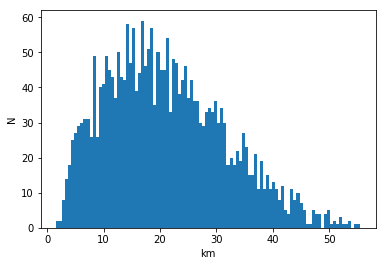

In [50]:
gauge_distances = pdist(coords_gauges)
gauge_hist = plt.hist(gauge_distances,bins=100)
plt.ylabel('N')
plt.xlabel('km')